In [1]:
import pandas as pd
import numpy as np

In [2]:
df_train = pd.read_csv('/kaggle/input/political-sentiment/PS_train.csv')

In [3]:
df_train[:5]

,content,labels
0,தென்காசி தொகுதி புதிய தமிழகம் கட்சி வேட்பாளர் ...,Neutral
1,அண்ணன் இதனை சூசகமாக 11 மாதங்கள் முன்பே பேட்டிய...,Substantiated
2,ஒரு வருடம் ஆகி விட்டது இந்த துயரம் நேர்ந்து......,Opinionated
3,"எடப்பாடியை கண்டுகொள்ளாத ""எடப்பாடி""🫢\n ---\nஆதர...",Positive
4,எங்களின் அரசியல் அடுத்த தலைமுறைக்குமானது \n#மக...,Opinionated


In [4]:
df_val = pd.read_csv('/kaggle/input/political-sentiment/PS_dev.csv')

In [5]:
df_val[:5]

,content,labels
0,ஒற்றே அறை...\n\nபாஜக குளோஸ்!\n\n#மக்களின்_சின்...,Opinionated
1,வாய்ப்பில்லை சார் வாய்ப்பில்லை\n#சீமானின்_சின்...,Substantiated
2,ஒரே போடு இரண்டாக பிளக்கும் | வரலாற்றில் ஒருவன்...,Neutral
3,இப்படியெல்லாம் எடிட் பண்ணிதான் ஓட்டு வாங்கணும்...,Negative
4,#Mike_VoiceOfPeople \n#NTK_Symbol_Mike \n#மக்க...,Substantiated


In [6]:
df_train = df_train.dropna()
df_val = df_val.dropna()

In [7]:
train_label_counts = df_train['labels'].value_counts()
print(train_label_counts)

labels
Opinionated          1361
Sarcastic             790
Neutral               637
Positive              575
Substantiated         412
Negative              406
None of the above     171
Name: count, dtype: int64


In [8]:
val_label_counts = df_val['labels'].value_counts()
print(val_label_counts)

labels
Opinionated          153
Sarcastic            115
Neutral               84
Positive              69
Substantiated         52
Negative              51
None of the above     20
Name: count, dtype: int64


In [9]:
df_merged = pd.concat([df_train, df_val], axis=0)

In [10]:
x_train = df_merged['content']
x_val = df_val['content']

In [11]:
replace_values = {
    "Opinionated" : 0,
    "Sarcastic" : 1,
    "Neutral" : 2,
    "Positive" : 3,
    "Substantiated" : 4,
    "Negative" : 5,
    "None of the above" : 6
}

In [12]:
y_train = df_merged['labels'].replace(replace_values)
y_val = df_val['labels'].replace(replace_values)

<ipython-input-12-3800ea415c6b>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_train = df_merged['labels'].replace(replace_values)
<ipython-input-12-3800ea415c6b>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_val = df_val['labels'].replace(replace_values)


In [13]:
y_train.value_counts()

labels
0    1514
1     905
2     721
3     644
4     464
5     457
6     191
Name: count, dtype: int64

In [14]:
y_val.value_counts()

labels
0    153
1    115
2     84
3     69
4     52
5     51
6     20
Name: count, dtype: int64

In [17]:
import tensorflow as tf
from keras_nlp.models import DebertaV3TextClassifierPreprocessor, DebertaV3TextClassifier
from keras.losses import SparseCategoricalCrossentropy
from keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense

In [18]:
preprocessor = DebertaV3TextClassifierPreprocessor.from_preset(
    "deberta_v3_base_multi",
    sequence_length=64,
    truncate="waterfall"
)

base_model = DebertaV3TextClassifier.from_preset(
    "deberta_v3_base_multi",
    num_classes=7,  
    preprocessor=preprocessor,
)

In [19]:
deberta = Model(inputs=base_model.input, outputs=base_model.backbone.output)

In [20]:
x_train_embeddings = deberta.predict(preprocessor(x_train))

153/153 ━━━━━━━━━━━━━━━━━━━━ 26s 124ms/step


In [21]:
x_val_embeddings = deberta.predict(preprocessor(x_val))

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step


In [22]:
x_train_embeddings.shape

(4896, 64, 768)

In [23]:
input_layer = Input(shape=(64, 768))

lstm_layer1 = LSTM(64, return_sequences=True)(input_layer)
dropout_layer1 = Dropout(0.5)(lstm_layer1)
lstm_layer2 = LSTM(32, return_sequences=False)(dropout_layer1)
dropout_layer2 = Dropout(0.5)(lstm_layer2)
output_layer = Dense(7, activation='softmax')(dropout_layer2)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 768)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64, 64)              │         213,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 64, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 225,895 (882.40 KB)

 Trainable params: 225,895 (882.40 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
history = model.fit(x_train_embeddings, y_train, epochs=100, batch_size=32, validation_data=(x_val_embeddings, y_val))

Epoch 1/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.2550 - loss: 1.8694 - val_accuracy: 0.3051 - val_loss: 1.7436
Epoch 2/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3116 - loss: 1.7636 - val_accuracy: 0.3051 - val_loss: 1.7096
Epoch 3/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3380 - loss: 1.7092 - val_accuracy: 0.3125 - val_loss: 1.6860
Epoch 4/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3434 - loss: 1.6892 - val_accuracy: 0.3180 - val_loss: 1.6578
Epoch 5/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3378 - loss: 1.6822 - val_accuracy: 0.3180 - val_loss: 1.6588
Epoch 6/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3464 - loss: 1.6913 - val_accuracy: 0.3217 - val_loss: 1.6456
Epoch 7/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3440 - loss: 1.6702 - val_accuracy: 0.3309 - val_loss: 1.6427
Epoch 8/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3562 - loss: 1.6556 - 

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize

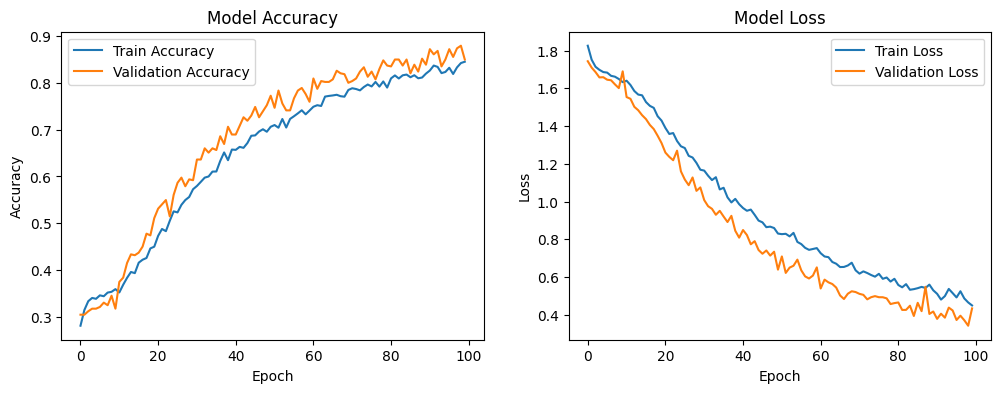

In [27]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.show()

# Testing data

In [28]:
df_test = pd.read_csv('/kaggle/input/political-sentiment/PS_test.csv')

In [29]:
df_test[:5]

,Id,content,labels
0,PS_01,இஸ்லாமிய சகோதரர்களுடன் ரமலான் கொண்டாடிய அதிமுக...,Neutral
1,PS_02,\nஓபிஎஸ் - எடப்பாடி போட்டா போட்டி! திடீரென பணி...,Negative
2,PS_03,இன்றைய பரப்புரை:\n\nநாம் தமிழர் கட்சி தலைமை ஒர...,Substantiated
3,PS_04,"🇰🇬🎙️ இன்னும் 05 ஏ நாளில், வெல்வோம் தமிழராய் - ...",Positive
4,PS_05,டாஸ்மாக்ல மட்டும்தான் கருணாநிதி அவர்களின் பெய...,Positive


In [30]:
x_test = df_test['content']
y_test = df_test['labels'].replace(replace_values)

<ipython-input-30-fa0004870769>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_test = df_test['labels'].replace(replace_values)


In [31]:
x_test_embeddings = deberta.predict(preprocessor(x_test))

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step


In [32]:
x_test_embeddings.shape

(544, 64, 768)

In [33]:
pred = model.predict(x_test_embeddings)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [38]:
y_pred = np.argmax(pred, axis=1)

In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [39]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision
precision = precision_score(y_test, y_pred, average='macro') 

# Calculate recall
recall = recall_score(y_test, y_pred, average='macro') 

# Calculate F1 Score
f1 = f1_score(y_test, y_pred, average='macro') 

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# classification report for detailed metrics per class
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=[str(i) for i in range(7)]))

Accuracy: 0.3162
Precision: 0.3143
Recall: 0.2997
F1 Score: 0.3026

Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.50      0.45       171
           1       0.36      0.36      0.36       106
           2       0.16      0.19      0.17        70
           3       0.23      0.12      0.16        75
           4       0.00      0.00      0.00        51
           5       0.10      0.13      0.11        46
           6       0.95      0.80      0.87        25

    accuracy                           0.32       544
   macro avg       0.31      0.30      0.30       544
weighted avg       0.30      0.32      0.30       544



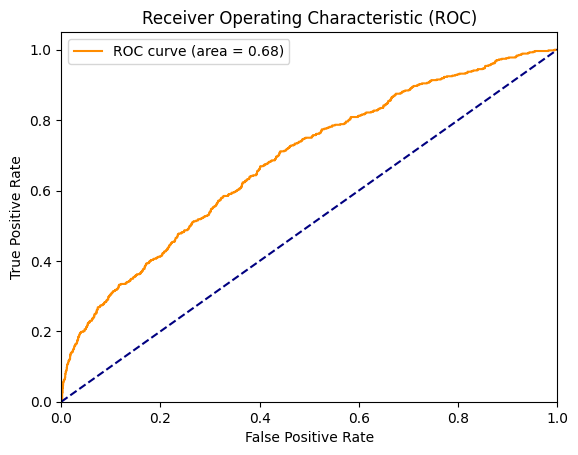

In [42]:
# ROC Curve
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6])

fpr, tpr, _ = roc_curve(y_test_binarized.ravel(), pred.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='best')
plt.show()

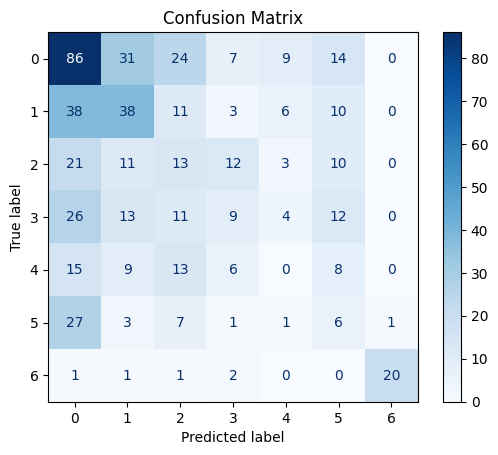

In [40]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()